In [1]:
!git pull

Already up to date.


In [2]:
# !python dqn_script_gw.py

In [3]:
from dqn_functions import * 

STATE_DIM = 2
ACTION_DIM = 110
BATCH_SIZE = 200

DQNModel = DQNNet(state_dim = STATE_DIM, 
                  output_size = ACTION_DIM, 
                  hidden_size = 120,
                  batch_size = BATCH_SIZE)

marketEnv1 = MarketEnv(action_size = ACTION_DIM)

losses, episode_rewards, epoch_rewards = run_dqn(DQNModel, 
                                                 marketEnv = marketEnv1,
                                                 batch_size = BATCH_SIZE,
                                                 epochs = 4000,
                                                 explore_epsilon = 0.2,
                                                 max_steps = 100,
                                                 sync_freq = 10)


In [4]:
env_id = "market"
np.savetxt("./output/%s_dqn_losses.txt"%env_id, losses)
np.savetxt("./output/%s_dqn_epoch_rewards.txt"%env_id, epoch_rewards)

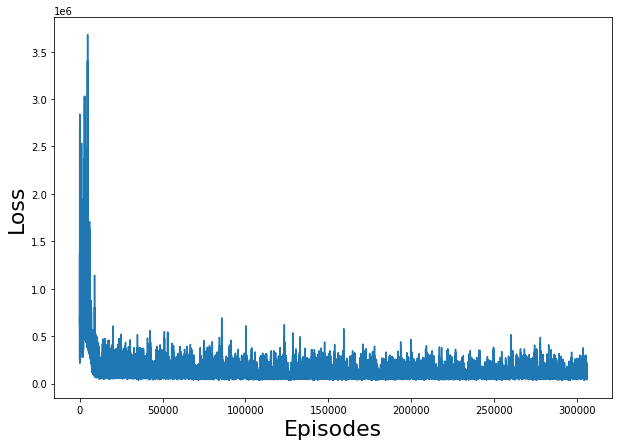

In [5]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Episodes",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.savefig("./output/%s_dqn_losses.png"%env_id)

Text(0, 0.5, 'Avg Reward')

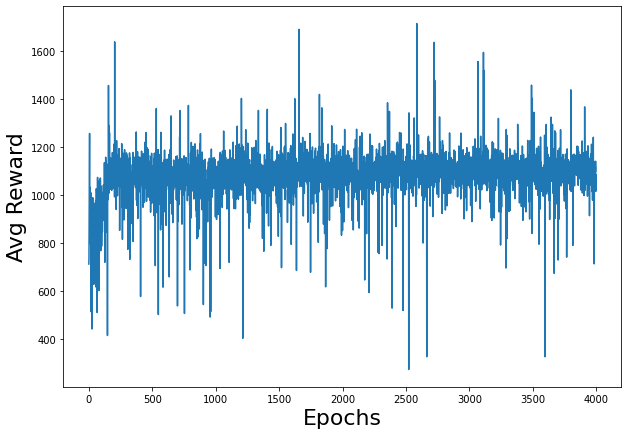

In [6]:
plt.figure(figsize=(10,7))
plt.plot(episode_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Avg Reward",fontsize=22)

In [7]:
len(episode_rewards)

4000

In [8]:
state = torch.from_numpy(np.array([2500, 30.0])).float().to(device = devid)
np.argmax(DQNModel(state).data.cpu().numpy())

89

In [9]:
state = torch.from_numpy(np.array([1200, 200.0])).float().to(device = devid)
np.argmax(DQNModel.model(state).data.cpu().numpy())

30

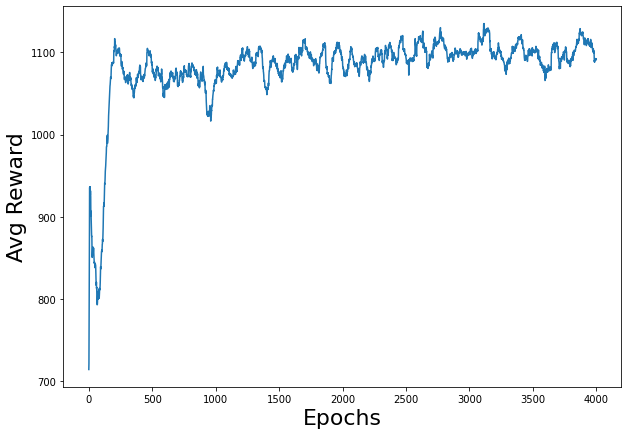

In [10]:
plt.figure(figsize=(10,7))
plt.plot(epoch_rewards)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Avg Reward",fontsize=22)
plt.savefig("./output/%s_dqn_avg_reward.png"%env_id)

In [11]:
np.mean(epoch_rewards[-50:])

1101.7480046474716

In [12]:
state = torch.from_numpy(np.array([2500, 10.0])).float().to(device = devid)
np.argmax(DQNModel.model(state).data.cpu().numpy())

89

In [13]:
state = torch.from_numpy(np.array([2500, 51.0])).float().to(device = devid)
np.argmax(DQNModel.model(state).data.cpu().numpy())

89

In [14]:
state = torch.from_numpy(np.array([2500, 100])).float().to(device = devid)
np.argmax(DQNModel(state).data.cpu().numpy())

47

In [15]:
state = torch.from_numpy(np.array([1250, 10.0])).float().to(device = devid)
np.argmax(DQNModel.model(state).data.cpu().numpy())

52

In [16]:
state = torch.from_numpy(np.array([1250, 51.0])).float().to(device = devid)
np.argmax(DQNModel.model(state).data.cpu().numpy())

49

In [17]:
state = torch.from_numpy(np.array([1250, 100])).float().to(device = devid)
np.argmax(DQNModel(state).data.cpu().numpy())

42

In [18]:
state = torch.from_numpy(np.array([50, 10.0])).float().to(device = devid)
np.argmax(DQNModel.model(state).data.cpu().numpy())

59

In [19]:
state = torch.from_numpy(np.array([50, 51.0])).float().to(device = devid)
np.argmax(DQNModel.model(state).data.cpu().numpy())

58

In [20]:
state = torch.from_numpy(np.array([50, 100])).float().to(device = devid)
np.argmax(DQNModel(state).data.cpu().numpy())

63

In [21]:
torch.save(DQNModel, "./output/%s_dqn_model.torch"%env_id)

In [22]:
dqn2 = torch.load("./output/%s_dqn_model.torch"%env_id)

In [23]:
state = torch.from_numpy(np.array([50, 100])).float().to(device = devid)
np.argmax(dqn2(state).data.cpu().numpy())

63